**Name** : Shubhajeet Das <br />
**Roll No.** : 24AI10013 <br />
DL Lab Assignment 4 -> **CNN**

# **Multi Class Image Classification**


Problem statement: You are given a dataset containing 10 classes of images. Implement a Convolutional Neural Network to classify the images into one of 10 classes

Basic inputs

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn               # Contains neural network layers, models (Classes)
import torch.nn.functional as F     # Contains functions which don't have learnable parameters (Activation functions, Loss functions)
import torch.optim as optim         # Contains different optimisation algos
import torchvision                  # Tools for Computer Vision Tasks - Datasets, Preprocessing tools, Pre trained models etc
import torchvision.transforms as transforms # Contains common image transformations
import torchvision.datasets as datasets
import torch.utils.data as data    # Utilities for data handling
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchinfo import summary     # Provides model information
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42
def set_all_seeds(seed):
    """
    Sets seeds for NumPy and PyTorch (not scikit-learn)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds(SEED)

# Data Collection & Exploration (5 marks)


**Load the Dataset (1 mark)**

 Load the [CIFAR10](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) dataset from torchvision

 Print dataset shape and class distribution






In [ ]:
traindata=datasets.CIFAR10('data',train=True,download=True)
testdata=datasets.CIFAR10('data',train=False,download=True)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


In [ ]:
traindata

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train

In [ ]:
print(f"Training Data Samples: {len(traindata)}")
print(f"Training Data Image Shape: {traindata.data.shape}")
print(f"Test Data Samples: {len(testdata)}")
print(f"Test Data Image Shape: {testdata.data.shape}")

Training Data Samples: 50000
Training Data Image Shape: (50000, 32, 32, 3)
Test Data Samples: 10000
Test Data Image Shape: (10000, 32, 32, 3)


In [ ]:
train_class_counts = torch.tensor(traindata.targets).bincount()
print("\nTraining Class Distribution:")
for i, count in enumerate(train_class_counts):
    print(f"  {traindata.classes[i]}: {count} samples")

test_class_counts = torch.tensor(testdata.targets).bincount()
print("\nTest Class Distribution:")
for i, count in enumerate(test_class_counts):
    print(f"  {testdata.classes[i]}: {count} samples")


Training Class Distribution:
  airplane: 5000 samples
  automobile: 5000 samples
  bird: 5000 samples
  cat: 5000 samples
  deer: 5000 samples
  dog: 5000 samples
  frog: 5000 samples
  horse: 5000 samples
  ship: 5000 samples
  truck: 5000 samples

Test Class Distribution:
  airplane: 1000 samples
  automobile: 1000 samples
  bird: 1000 samples
  cat: 1000 samples
  deer: 1000 samples
  dog: 1000 samples
  frog: 1000 samples
  horse: 1000 samples
  ship: 1000 samples
  truck: 1000 samples


**Visualize the Dataset (1 mark)**

Print 3 random images from each class along with their corresponding labels

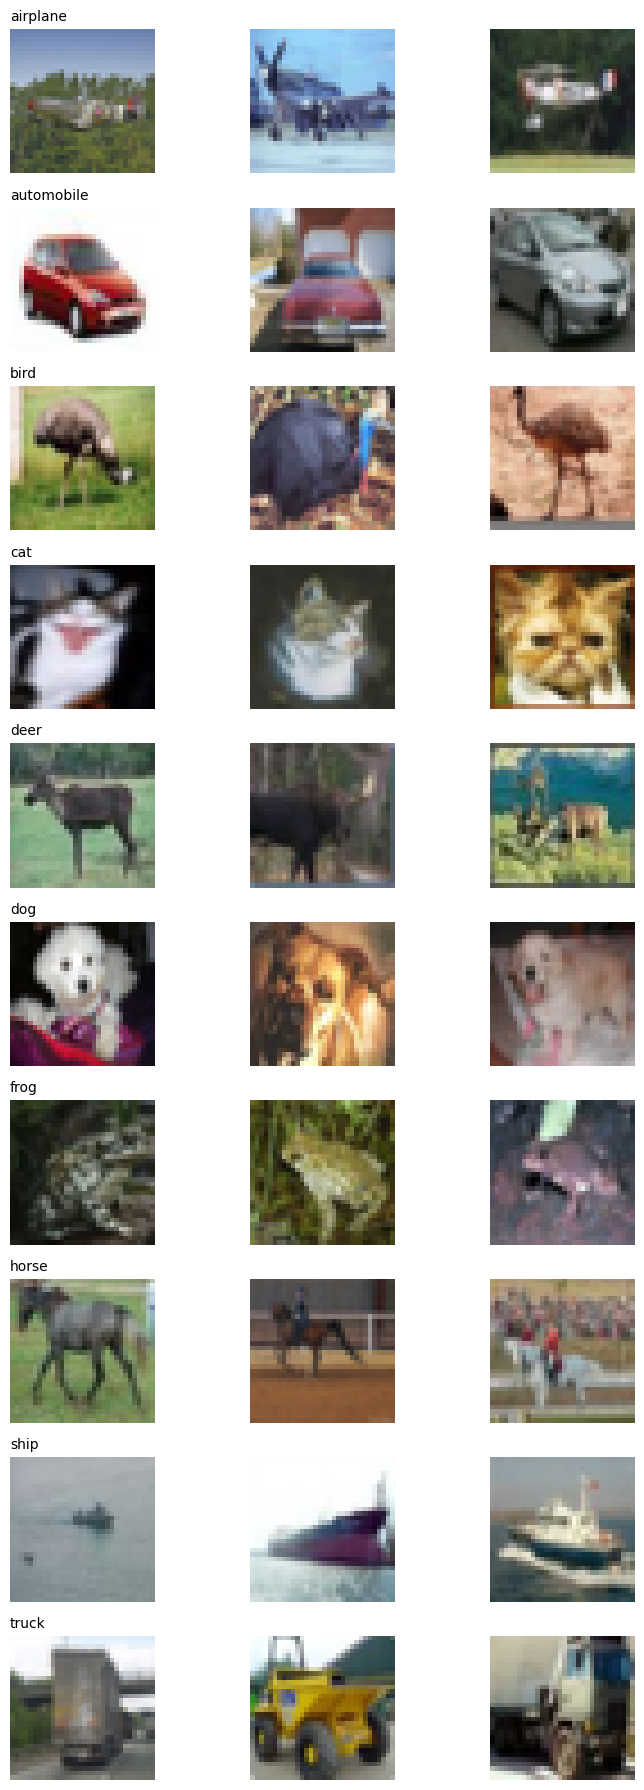

In [ ]:
fig, axes = plt.subplots(10, 3, figsize=(8, 18))
for i, class_name in enumerate(traindata.classes):
    class_indices = [idx for idx, target in enumerate(traindata.targets) if traindata.classes[target] == class_name]
    random_indices = random.sample(class_indices, 3)
    for j, img_idx in enumerate(random_indices):
        img, label = traindata[img_idx]
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(class_name, loc="left", fontsize=10)
plt.tight_layout()
plt.show()

**Preprocessing (1 mark)**

Normalize the images

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
trainset=datasets.CIFAR10('data',train=True,download=True,transform=transform)
testset=datasets.CIFAR10('data',train=False,download=True, transform=transform)

**Data Preparation (2 marks)**

1. Define the train split into training (80%) and validation (20%) partitions
2. Define corresponding dataloaders



In [ ]:
val_size = int(0.2*len(trainset))
train_size = len(trainset) - val_size
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = random_split(
    trainset, [train_size, val_size], generator=generator
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

# Model Architecture and Training (15 marks)

**Baseline (4 marks)**

Design a convolutional neural network model with the following architecture (3 marks):

1.  Convolution layer 1 (16 filters, kernel=5, padding=2) + ReLU + MaxPool(kernel=2, stride=2)
2.  Convolution layer 2 (32 filters, kernel=3, padding=1) + ReLU + MaxPool(kernel=2, stride=2)
3.  Convolution layer 3 (64 filters, kernel=3, padding=1) + ReLU + MaxPool(kernel=2, stride=2)
4.  Fully connected layer (128 neurons)
5.  Output layer (number of classes)

Choose an appropriate output activation function

Print the model architecture, number of trainable parameters and the dimensions of the output of each layer (1 mark)

Hyperparameters


*   Batch size = 64
*   Learning Rate = 0.001
*   Dropout = 0.6
*   Number of Epochs = 10

You are free to experiment with the hyperparameters. Justify your choices using comments



In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

print("BaselineCNN class defined.")

BaselineCNN class defined.


In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.6
NUM_EPOCHS = 10

In [ ]:
baseline_model = BaselineCNN(num_classes=10)
print("Baseline Model Architecture and Summary:")
summary(baseline_model, input_size=(BATCH_SIZE, 3, 32, 32))

Baseline Model Architecture and Summary:


Layer (type:depth-idx)                   Output Shape              Param #
BaselineCNN                              [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 32, 32]          1,216
├─ReLU: 1-2                              [64, 16, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 16, 16, 16]          --
├─Conv2d: 1-4                            [64, 32, 16, 16]          4,640
├─ReLU: 1-5                              [64, 32, 16, 16]          --
├─MaxPool2d: 1-6                         [64, 32, 8, 8]            --
├─Conv2d: 1-7                            [64, 64, 8, 8]            18,496
├─ReLU: 1-8                              [64, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [64, 64, 4, 4]            --
├─Linear: 1-10                           [64, 128]                 131,200
├─ReLU: 1-11                             [64, 128]                 --
├─Linear: 1-12                           [64, 10]                  1,2

**Training function (2 marks)**

Write a function that takes the model name as parameter, trains the model, and prints training and validation losses against number of epochs

Use a suitable loss function and Adam optimizer


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

print("train_model function defined.")

train_model function defined.


In [ ]:
def show_train_results(model, train_loader, val_loader, label="baseline"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print(f"Training {label} model...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
    plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss over Epochs for {label} Model')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"{label} model training complete and losses plotted.")

**Evaluation function (2 marks)**

Write a function that takes the model name as parameter, evaluates the model on the test set and reports the following evaluation metrics:


1.   Accuracy
2.   Precision
3.   Recall
4.   F1 score
5.   Confusion matrix



In [ ]:
class_names = traindata.classes
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model(inputs)
            outputs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Evaluation metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    # Print results
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return accuracy, precision, recall, f1
print("Evaluation function defined")

Evaluation function defined


**Train the baseline model and evaluate it (1 mark)**

Training baseline model...
Epoch 1/10: Train Loss: 1.5495, Val Loss: 1.3041
Epoch 2/10: Train Loss: 1.1863, Val Loss: 1.0979
Epoch 3/10: Train Loss: 1.0090, Val Loss: 0.9570
Epoch 4/10: Train Loss: 0.8884, Val Loss: 0.9016
Epoch 5/10: Train Loss: 0.7876, Val Loss: 0.9322
Epoch 6/10: Train Loss: 0.7106, Val Loss: 0.8515
Epoch 7/10: Train Loss: 0.6363, Val Loss: 0.8554
Epoch 8/10: Train Loss: 0.5731, Val Loss: 0.8138
Epoch 9/10: Train Loss: 0.5184, Val Loss: 0.8606
Epoch 10/10: Train Loss: 0.4540, Val Loss: 0.8840


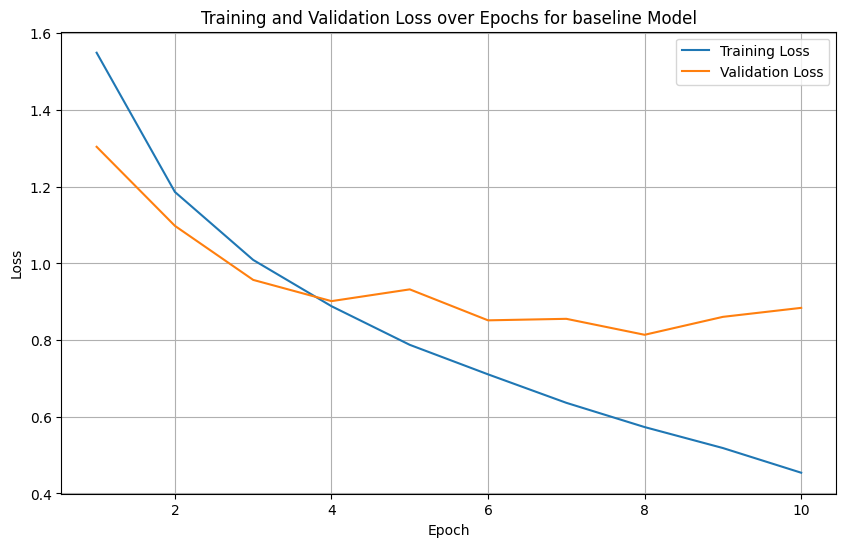

baseline model training complete and losses plotted.


In [ ]:
show_train_results(baseline_model, train_loader, val_loader)

Test Accuracy: 0.7171
Test Precision: 0.7200
Test Recall: 0.7171
Test F1-Score: 0.7162


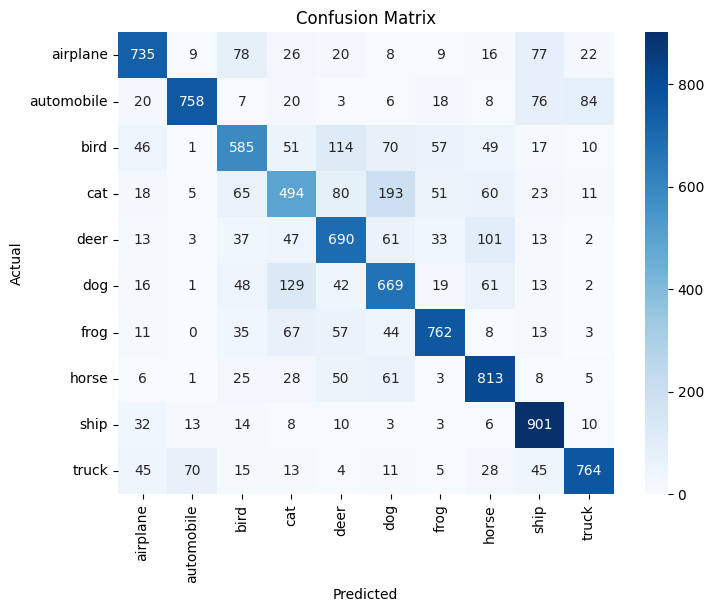

In [ ]:
baseline_acc, baseline_pre, baseline_rec, baseline_f1 = evaluate_model(baseline_model, test_loader)

**Variant 1 (2 marks)**

Modify the baseline by including Batch Norm after Activation in all 3 layers

Print the model architecture and number of trainable parameters

In [ ]:
class Variant1CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Variant1CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

print("Variant1CNN class defined.")

Variant1CNN class defined.


In [ ]:
variant1_model = Variant1CNN(num_classes=10)
print("Variant1CNN Model Architecture and Summary:")
summary(variant1_model, input_size=(BATCH_SIZE, 3, 32, 32))

Variant1CNN Model Architecture and Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Variant1CNN                              [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 32, 32]          1,216
├─ReLU: 1-2                              [64, 16, 32, 32]          --
├─BatchNorm2d: 1-3                       [64, 16, 32, 32]          32
├─MaxPool2d: 1-4                         [64, 16, 16, 16]          --
├─Conv2d: 1-5                            [64, 32, 16, 16]          4,640
├─ReLU: 1-6                              [64, 32, 16, 16]          --
├─BatchNorm2d: 1-7                       [64, 32, 16, 16]          64
├─MaxPool2d: 1-8                         [64, 32, 8, 8]            --
├─Conv2d: 1-9                            [64, 64, 8, 8]            18,496
├─ReLU: 1-10                             [64, 64, 8, 8]            --
├─BatchNorm2d: 1-11                      [64, 64, 8, 8]            128
├─MaxPool2d: 1-12                        [64, 64, 4, 4]            --
├─Li

**Train the variant 1 model and evaluate it (1 mark)**

Training variant 1 model...
Epoch 1/10: Train Loss: 1.2381, Val Loss: 1.0120
Epoch 2/10: Train Loss: 0.8789, Val Loss: 0.8986
Epoch 3/10: Train Loss: 0.7111, Val Loss: 0.8023
Epoch 4/10: Train Loss: 0.5874, Val Loss: 0.8049
Epoch 5/10: Train Loss: 0.4872, Val Loss: 0.8037
Epoch 6/10: Train Loss: 0.3968, Val Loss: 0.8278
Epoch 7/10: Train Loss: 0.3144, Val Loss: 0.9154
Epoch 8/10: Train Loss: 0.2640, Val Loss: 0.9650
Epoch 9/10: Train Loss: 0.2030, Val Loss: 1.0712
Epoch 10/10: Train Loss: 0.1781, Val Loss: 1.1239


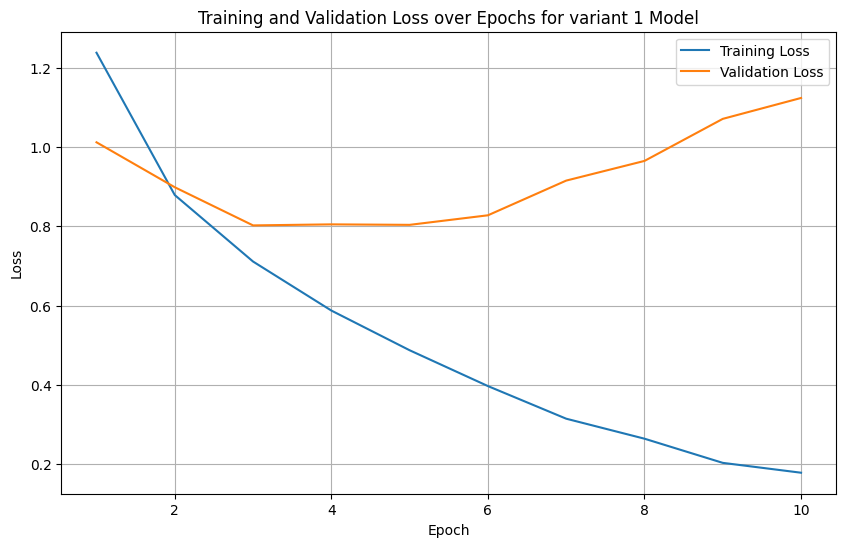

variant 1 model training complete and losses plotted.


In [ ]:
show_train_results(variant1_model, train_loader, val_loader, "variant 1")

Test Accuracy: 0.7201
Test Precision: 0.7229
Test Recall: 0.7201
Test F1-Score: 0.7207


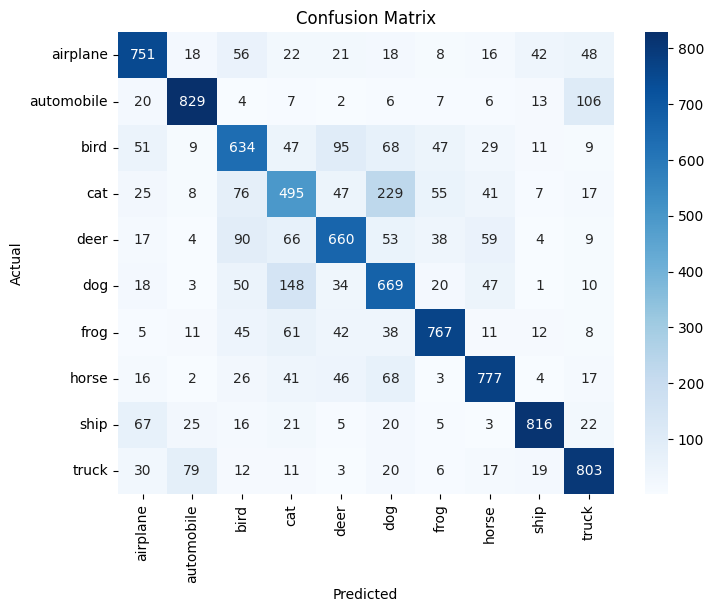

In [ ]:
v1_acc, v1_pre, v1_rec, v1_f1 = evaluate_model(variant1_model, test_loader)

**Variant 2 (2 marks)**

Modify the baseline by including dropout after the fully connected layer

Print the model architecture and number of trainable parameters

In [ ]:
class Variant2CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Variant2CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

print("Variant2CNN class defined.")

Variant2CNN class defined.


In [ ]:
variant2_model = Variant2CNN(num_classes=10)
print("Variant2CNN Model Architecture and Summary:")
summary(variant2_model, input_size=(BATCH_SIZE, 3, 32, 32))

Variant2CNN Model Architecture and Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Variant2CNN                              [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 32, 32]          1,216
├─ReLU: 1-2                              [64, 16, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 16, 16, 16]          --
├─Conv2d: 1-4                            [64, 32, 16, 16]          4,640
├─ReLU: 1-5                              [64, 32, 16, 16]          --
├─MaxPool2d: 1-6                         [64, 32, 8, 8]            --
├─Conv2d: 1-7                            [64, 64, 8, 8]            18,496
├─ReLU: 1-8                              [64, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [64, 64, 4, 4]            --
├─Linear: 1-10                           [64, 128]                 131,200
├─ReLU: 1-11                             [64, 128]                 --
├─Dropout: 1-12                          [64, 128]                 --


**Train the variant 2 model and evaluate it (1 mark)**

Training variant 2 model...
Epoch 1/10: Train Loss: 1.7161, Val Loss: 1.4550
Epoch 2/10: Train Loss: 1.4175, Val Loss: 1.2415
Epoch 3/10: Train Loss: 1.2705, Val Loss: 1.1388
Epoch 4/10: Train Loss: 1.1632, Val Loss: 1.0074
Epoch 5/10: Train Loss: 1.0686, Val Loss: 0.9656
Epoch 6/10: Train Loss: 1.0077, Val Loss: 0.9162
Epoch 7/10: Train Loss: 0.9527, Val Loss: 0.8910
Epoch 8/10: Train Loss: 0.9045, Val Loss: 0.8690
Epoch 9/10: Train Loss: 0.8663, Val Loss: 0.8560
Epoch 10/10: Train Loss: 0.8284, Val Loss: 0.8435


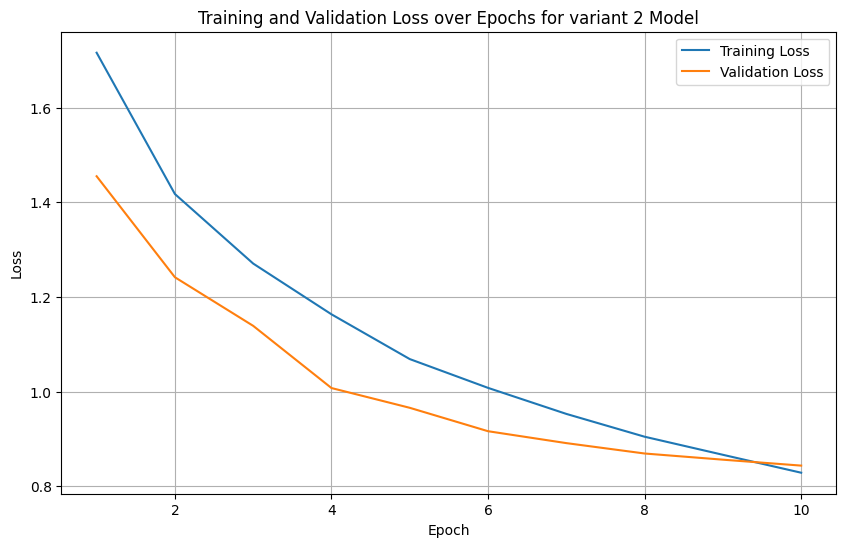

variant 2 model training complete and losses plotted.


In [ ]:
show_train_results(variant2_model, train_loader, val_loader, "variant 2")

Test Accuracy: 0.7040
Test Precision: 0.7033
Test Recall: 0.7040
Test F1-Score: 0.7005


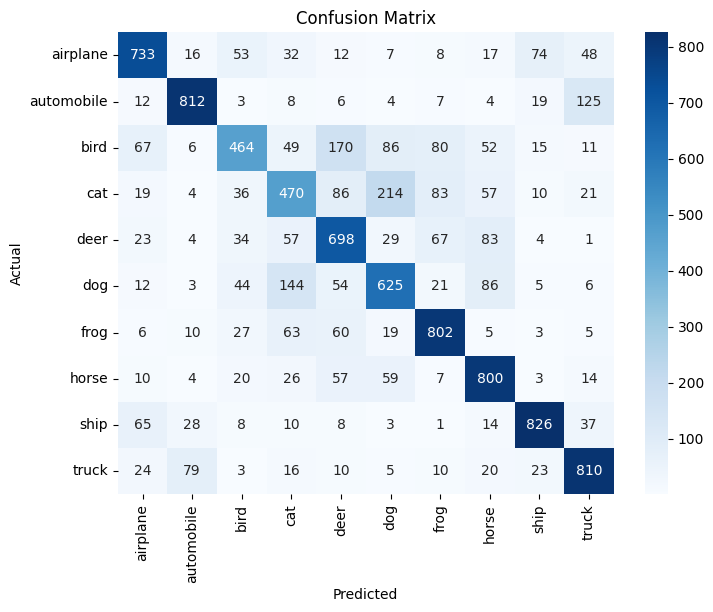

In [ ]:
v2_acc, v2_pre, v2_rec, v2_f1 = evaluate_model(variant2_model, test_loader)

# Answer the following questions: (5 marks)


1. Compare the performance of the 3 models. Is accuracy a sufficient metric to evaluate the models?
2. Compare the convergence speed (number of epochs to reach minimum loss) of the 3 models. How does batch norm affect convergence speed?
3. How does dropout work during inference?
4. What would happen if we used dropout after the convolution layer?
5. Which two classes are most confused? Why is it so?




1.

In [ ]:
print('\033[1m' + 'Comparing model performance' + '\033[0m')
print("Baseline model")
print(f"Accuracy : {baseline_acc:.4f}, Precision: {baseline_pre:.4f}, Recall: {baseline_rec:.4f}, F1 Score: {baseline_f1:.4f}")
print("Variant 1 model")
print(f"Accuracy : {v1_acc:.4f}, Precision: {v1_pre:.4f}, Recall: {v1_rec:.4f}, F1 Score: {v1_f1:.4f}")
print("Variant 2 model")
print(f"Accuracy : {v2_acc:.4f}, Precision: {v2_pre:.4f}, Recall: {v2_rec:.4f}, F1 Score: {v2_f1:.4f}")

Comparing model performance
Baseline model
Accuracy : 0.7171, Precision: 0.7200, Recall: 0.7171, F1 Score: 0.7162
Variant 1 model
Accuracy : 0.7201, Precision: 0.7229, Recall: 0.7201, F1 Score: 0.7207
Variant 2 model
Accuracy : 0.7040, Precision: 0.7033, Recall: 0.7040, F1 Score: 0.7005


2. Yes accuracy is sufficient to evaluate in this case because, Variant 1 model with highest accuracy also leads in precision, recall and f1 score.

3. During inference, the dropout layer is turned off, and all neurons are active.

4. The model performance would be degraded if we used dropout after the convolution layer.

5. Cat and Dog are the most confused (this can be seen from the confusion matrix).